# Python Implementation of NSGA II
The code below implements the NSGA algorithm as explained in `6. Multi Objective Optimization & NSGA II.ipynb`.

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
import math

 First the `MOO_Problem` class is implemented, which allows any `m` number of constraint function. Each constrained function applied on a `(Nxd)` numpy matrix, where `d` is the dimension of the decision variable.

In [2]:
class MOO_Problem():
    '''
    Class defines the dfferent constraint function that are needed to be minimized.
    Param:
        d: Dimension of input vector for the constraint functions
        lower: (mx1) numpy array giving lower bound of the m constraints. Default = -1
        upper: (mx1) numpy array giving upper bound of the m constraints. Default = 1
        *args: m constraints in the form of python functions capable of running on (Nxd) numpy arrays
    Usage: MOO_Problem(func1, func2, func3, ...)
    '''
    def __init__(self, *args, d=None,lower=None, upper=None):
        if d is None:
            print("Missing required parameter 'd'")
            sys.exit(-1)
        self.d = d
        self.m = len(args)
        if self.m < 1:
            print("Enter atleast one constraint function")
            sys.exit(-1)
        self.constraints = list(args)
        self.lower = lower if lower is not None else -np.ones((1, self.d))
        self.upper = upper if upper is not None else np.ones((1, self.d))
    
    def evaluate(self, x):
        '''
        Evaluate the constriants on multiple possible vectors
        Param: x: (N, m) numpy matrix where N is number of vectors and m is number of constraints
        Return: (N, m) numpy array of evaluated results
        '''
        N = x.shape[0]
        obj = np.empty((N, self.m))
        for i in range(self.m):
            obj[:, i] = np.squeeze(self.constraints[i](x))
        return obj

Next, the `NSGAII` class is implemented. The important parameters of this class are:
* `moo_problem`: The MOO problem that needs to be optimized. We assume taht all constraints need to be **minimized**.
* `pop_size`: Number of individuals in the population at every iteration.
* `p_mutate`: Probability of mutation.
* `p_crossover`: Probabilty of crossover
* `n_iter`: Maximum number of iterations
* `max_evals`: Maximum number of function evaluations allowed
* `initial_pop`: Initial population to begin algorithm. If not provided, sampled randomly.

`p_mutate`/`p_crossover` can effect the algorithm significantly. Below, the change in the offspring w.r.t. its parents due to crossover is plotted, for varying values of `p_crossover`.

![Effect of p_crossover](Images/nsga_prob_crossover.png)

Another set of parameters that have not been made available through the class, but can be edited directly inside the function `NSGAII.evolve()` is `dis_c`/`dis_m`. Below shows the distribution of the same change based on different values of `dis_c` with `p_crossover = 1`.

![Effect of dis_c](Images/nsga_dis_c.png)

For the entire algorithm, we observe the trend that for very high values of `dis_c`/`dis_m`, the pareto optimal achieved is less diverse.

In [3]:
class NSGAII():
    '''
    Class to run the NSGA II algorithm
    '''
    def __init__(self, moo_problem, pop_size=100 , p_mutate=1.0, p_crossover=1.0, n_iter=100, max_evals= 100*500, initial_pop=None):
        '''
        Param:
            moo_problem: Multi objective problem of class MOO_Problem
            pop_size: Number of individuals to maintain in each iteration
            p_mutate: probability of mutation (between 0 and 1, default 1)
            p_crossover: probabilty of crossover (between 0 and 1, default 1)
            n_iter: Maximum number of iterations allowed (default = 100)
            max_evals: Maximum number of function evaluations allowed (default = 500 per individual)
            initial_pop: (Nxd) numpy array of initial population of individuals. If None then randomly initialized
        '''
        self.N = pop_size
        self.p_m = p_mutate
        self.p_c = p_crossover
        self.max_iter = n_iter
        self.max_evals = max_evals
        self.moo = moo_problem
        if initial_pop is not None and initial_pop.shape[1]==self.moo.d:
            self.pop = [initial_pop, self.moo.evaluate(initial_pop)]
        else:
            if initial_pop is not None:
                print("Initial population passed has wrong dimensions. Initializing random population...")
            random_pop = np.random.random((self.N, self.moo.d)) * (self.moo.upper - self.moo.lower) + self.moo.lower
            self.pop = [random_pop, self.moo.evaluate(random_pop)]            

    def non_dominated_sort(self, n_sort=None):
        '''
        Performs non dominated sort of the population in this iteration
        Param: n_sort: maximum number of individuals to sort
        Return:
            front_ids: (Nx1) vctor where front_id[i] is the front number of pop[i]
            max_front: Number of fronts calculated
        '''
        # Initialization
        pop_cost = self.pop[1]
        N = pop_cost.shape[0]
        _, loc = np.unique(pop_cost[:,0], return_inverse=True)
        if n_sort is None: n_sort = len(loc)
        sorted_cost = pop_cost[pop_cost[:,0].argsort(), :]
        front_id = np.inf*np.ones(N)
        max_front = 0
        #Non dominated sort
        while np.sum(front_id < np.inf) < n_sort:      # while individuals left without front_id
            max_front += 1
            for i in np.where(front_id==np.inf)[0]:
#                 if np.sum(front_id < np.inf) >= n_sort: break
                dominated = False
                for j in range(i, 0, -1):
                    if front_id[j-1] == max_front:
                        m=2
                        while(m<=self.moo.m) and (sorted_cost[i, m-1] >= sorted_cost[j-1, m-1]):
                            m += 1
                        dominated = m > self.moo.m
                        if dominated or self.moo.m==2:
                            break
                if not dominated:
                    front_id[i] = max_front
        return front_id[loc], max_front
        
    def crowding_distance(self, front_id):
        '''
        Calculate the crowding distance for each pareto front
        Param: front_id: (Nx1) numpy array where front_i[i] is the front number for pop[i]
        Return: crowd_dis: (Nx1) numpy array of crowding distances
        '''
        N = self.pop[0].shape[0]
        pop_cost = self.pop[1]
        crowd_dis = np.zeros(N)
        fronts = np.unique(front_id)
        fronts = fronts[fronts!=np.inf]
        
        for f in range(len(fronts)):
            front = np.where(front_id==f+1)[0]
            fmax = np.max(pop_cost[front, :], axis=0)
            fmin = np.min(pop_cost[front, :], axis=0)
            for i in range(self.moo.m):
                rank = np.argsort(pop_cost[front, i])
                crowd_dis[front[rank[0]]] = np.inf
                crowd_dis[front[rank[-1]]] = np.inf
                for j in range(1, len(front)-1):
                    crowd_dis[front[rank[j]]] = crowd_dis[front[rank[j]]] + \
                            (pop_cost[front[rank[j+1]], i] - pop_cost[front[rank[j-1]], i]) / (fmax[i]-fmin[i])
        return crowd_dis
    
    def tournament(self, fit, K=2):
        '''
        Perform crowded tournament
        Param:
            K: Number of parameters to be considered for fitness
            fit: (N, K) matrix of fitness values, where the higher column means higher preference
        Return: indices of individuals who won the tournament
        '''
        n_total = len(fit)
        a = np.random.randint(n_total, size=self.N)
        b = np.random.randint(n_total, size=(self.N, K))
        for i in range(self.N):
            for j in range(K):
                for r in range(fit[0, :].size):
                    if fit[b[i, j], r] < fit[a[i], r]:
                        a[i] = b[i,j]
        return a
    
    def evolve(self, parents, boundary=None):
        ''' Creates the offspring from parents through crossover + mutation
        Param:
            parents: (Nxm) matrix of parents to participate in mutation
            boundary: (lower, upper) bounds of the constraints. Defualt value taken from moo problem.
        '''
        dis_c, dis_m = 20, 20
        parents = parents[:(len(parents)//2)*2, :]
        (n, d) = parents.shape
        parent_1, parent_2 = parents[:n//2, :], parents[n//2:, :]
        
        ## CROSSOVER
        beta = np.empty((n//2, d))
        mu = np.random.random((n//2, d))
        beta[mu <= 0.5]= np.power(2 * mu[mu <= 0.5], 1 / (dis_c + 1))
        beta[mu > 0.5] = np.power(2 * mu[mu > 0.5], -1 / (dis_c + 1))
        beta = beta * ((-1)** np.random.randint(2, size=(n // 2, d)))
        beta[np.random.random((n // 2, d)) < 0.5] = 1
        beta[np.tile(np.random.random((n // 2, 1)) > self.p_c, (1, d))] = 1
        # beta=1 means no crossover
        
        offspring = np.vstack(((parent_1 + parent_2) / 2 + beta * (parent_1 - parent_2) / 2,
                                   (parent_1 + parent_2) / 2 - beta * (parent_1 - parent_2) / 2))

        ## MUTATION
        site = np.random.random((n, d)) < self.p_m / d
        mu = np.random.random((n, d))
        temp = site & (mu <= 0.5)
        if boundary is None:
            lower, upper = np.tile(self.moo.lower, (n, 1)), np.tile(self.moo.upper, (n,1))
        else:
            lower, upper = boundary
        norm = (offspring[temp] - lower[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp]) * \
                               (np.power(2. * mu[temp] + (1. - 2. * mu[temp]) * np.power(1. - norm, dis_m + 1.),
                                         1. / (dis_m + 1)) - 1.)
        temp = ~temp
        norm = (upper[temp] - offspring[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp])* \
                               (1. - np.power(
                                   2. * (1. - mu[temp]) + 2. * (mu[temp] - 0.5) * np.power(1. - norm, dis_m + 1.),
                                   1. / (dis_m + 1.)))
        offspring = np.maximum(np.minimum(offspring, upper), lower)
        return offspring
    
    def selection(self):
        '''Performs the environment selection based on the front_ids and crowding_distance
        '''
        front_id, max_front = self.non_dominated_sort(n_sort=self.N)
        next_label = np.zeros(front_id.shape[0], dtype=bool)
        next_label[front_id<max_front] = True
        crowd_dis = self.crowding_distance(front_id)
        last = np.where(front_id==max_front)[0]
        rank = np.argsort(-crowd_dis[last])
        delta_n = rank[:(self.N - int(np.sum(next_label)))]
        next_label[last[delta_n]] = True
        index = np.where(next_label)[0]
        self.pop = [self.pop[0][index, :], self.pop[1][index, :]]
        return front_id[index], crowd_dis[index], index
    
    def run(self):
        front_id, max_front = self.non_dominated_sort()
        crowd_dis = self.crowding_distance(front_id)
        
        eval_left, n_iter = self.max_evals, 0
        while eval_left >= 0 and n_iter <= self.max_iter:
            fit = np.vstack((front_id, crowd_dis)).T
            mating_pool = self.tournament(fit)
            parent = [self.pop[0][mating_pool, :], self.pop[1][mating_pool, :]]
            offspring = self.evolve(parent[0])
            offspring_cost = self.moo.evaluate(offspring)
            self.pop = [np.vstack((self.pop[0], offspring)), np.vstack((self.pop[1], offspring_cost))]
            front_id, crowd_dis, _ = self.selection()
            eval_left -= self.N
            n_iter +=1
                
        print("Num iteration: {}, Num. function evaluations: {}".format(n_iter, self.max_evals-eval_left))
        return self.pop
        
    def visualize(self):
        _ = self.run()
        pop_cost = self.pop[1]
        front_id, max_front = self.non_dominated_sort()
        non_dominated = pop_cost[front_id==1, :]
        if self.moo.m == 2:
            ax = plt.subplot(111)
            ax.scatter(non_dominated[:, 0], non_dominated[:, 1])
        elif self.moo.m == 3:
            x, y, z = non_dominated[:, 0], non_dominated[:, 1], non_dominated[:, 2]
            ax = plt.subplot(111, projection='3d')
            norm =  (non_dominated - non_dominated.min(0)) / non_dominated.ptp(0)
            ax.scatter(x, y, z, c=norm)
        else:
            
            for i in range(len(non_dominated)):
                ax = plt.subplot(3,len(non_dominated)//3+1, i)
                ax.plot(range(1, self.moo.m + 1), non_dominated[i, :])
        return ax

## Applying NSGAII
We now apply NSGAA II on different problems:

### Simple example
For the first example, we minimize the following two simple constraints:
$$f_1(x) = (x+2)^2-10$$
$$f_2(x) = (x-2)^2+20$$

Num iteration: 101, Num. function evaluations: 5050


Text(0, 0.5, 'f2(x)')

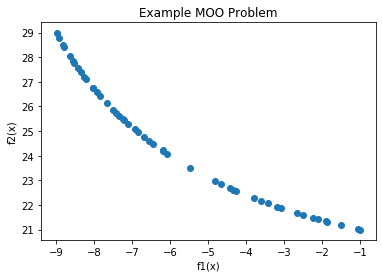

In [4]:
#First function to optimize
def function1(x):
    value = (np.square(x+2) - 10)
    return value

#Second function to optimize
def function2(x):
    value = (np.square(x-2) + 20)
    return value

moo_problem = MOO_Problem(function1, function2, d=1)
nsgaii = NSGAII(moo_problem, pop_size=50, n_iter=100)
ax = nsgaii.visualize()
ax.set_title('Example MOO Problem')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')

Now, we will apply the algorithm on some common multi objective problems used to benchmark algorithms.

Most of these can be found on the Wikipedia article: [Test function for multi-objective optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization#Test_functions_for_multi-objective_optimization).

### DTLZ 2
See [here](https://sop.tik.ee.ethz.ch/download/supplementary/testproblems/dtlz2/index.php) for more information.

Num iteration: 101, Num. function evaluations: 10100


Text(0.5, 0, 'f3(x)')

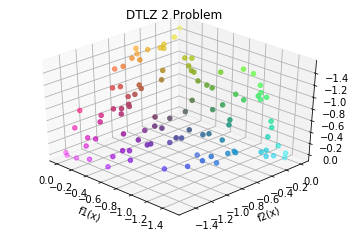

In [5]:
## DTLZ 2 Problem

m = 3
d = 4
lb = np.array([[0]*d])
ub = np.array([[1]*d])

def g(x):
    return np.sum(np.square(x[:, 2:]-0.5), axis=1)

def f1(x):
    return -((1+g(x))*np.cos(np.pi/2*x[:, 0])*np.cos(np.pi/2*x[:, 1]))

def f2(x):
    return -((1+g(x))*np.sin(np.pi/2*x[:, 1])*np.cos(np.pi/2*x[:, 0]))

def f3(x):
    return -((1+g(x))*np.sin(np.pi/2*x[:, 0]))

moo_problem = MOO_Problem(f1, f2, f3, d=d, lower=lb, upper=ub)
nsgaii = NSGAII(moo_problem, pop_size=100, n_iter=100)
ax = nsgaii.visualize()
ax.view_init(elev=-145., azim=45)
ax.set_title('DTLZ 2 Problem')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
ax.set_zlabel('f3(x)')

### Fonesca-Fleming Function

Num iteration: 101, Num. function evaluations: 10100


Text(0, 0.5, 'f2(x)')

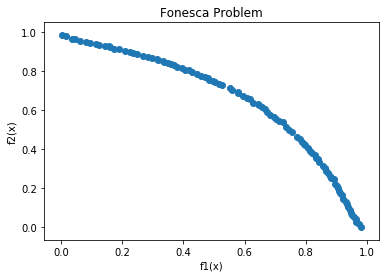

In [6]:
## Fonesca Problem
lb = np.array([[-4, -4, -4]])
ub = np.array([[4, 4, 4]])

def fonseca1(x):
    val = 1-np.exp(-np.sum(np.square(x-1/math.sqrt(3)), axis=1))
    return val

def fonseca2(x):
    val = 1-np.exp(-np.sum(np.square(x+1/math.sqrt(3)), axis=1))
    return val

moo_problem = MOO_Problem(fonseca1, fonseca2, d=3, lower=lb, upper=ub)
nsgaii = NSGAII(moo_problem, pop_size=100, n_iter=100)
ax = nsgaii.visualize()
ax.set_title('Fonesca Problem')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')

### Viennet function

Num iteration: 101, Num. function evaluations: 10100


Text(0.5, 0, 'f3(x)')

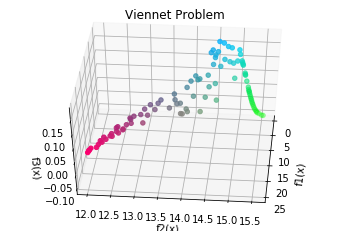

In [7]:
## Viennet Problem
lb = np.array([[-5, -5]])
ub = np.array([[5, 5]])

def f1(x):
    val = 0.5*np.sum(x**2, axis=1) + np.sin(np.sum(x**2, axis=1))
    return val

def f2(x):
    val = (3*x[:, 0]-2*x[:, 1]+4)/8 + (x[:, 0]-x[:, 1]+1)/27 +15
    return val

def f3(x):
    val = 1/(np.sum(x**2, axis=1)+1) - 1.1*np.exp(-np.sum(x**2, axis=1))
    return val

moo_problem = MOO_Problem(f1, f2, f3, d=2, lower=lb, upper=ub)
nsgaii = NSGAII(moo_problem, pop_size=100, n_iter=100)
ax = nsgaii.visualize()
ax.view_init(elev=45., azim=5)
ax.set_title('Viennet Problem')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
ax.set_zlabel('f3(x)')

### Kursawe Function

Num iteration: 101, Num. function evaluations: 10100


Text(0, 0.5, 'f2(x)')

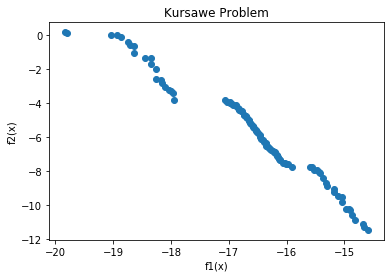

In [8]:
#Kursawe function
lb = np.array([[-5]*3])
ub = np.array([[5]*3])

def f1(x):
    sq_x = x**2
    return -10*np.exp(-0.2*np.sqrt(np.sum(sq_x[:, :2], axis=1))) - 10*np.exp(-0.2*np.sqrt(np.sum(sq_x[:, 1:], axis=1)))

def f2(x):
    return np.sum(np.power(np.abs(x), 0.8) + 5*np.sin(x**3), axis=1)

moo_problem = MOO_Problem(f1, f2, d=3, lower=lb, upper=ub)
nsgaii = NSGAII(moo_problem, pop_size=100, n_iter=100)
ax = nsgaii.visualize()
ax.set_title('Kursawe Problem')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')